In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange

In [2]:
N = 16
two_N = 32
nearest_square = 36
sqrt_N = 6

n = torch.arange(nearest_square)
omegas = torch.exp(2j * torch.pi * n / nearest_square)

In [20]:
def ref_dft_matrix(N):
    """Compute the DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(-2j * torch.pi * n * k / N)
    return torch.view_as_real(M)

def ref_idft_matrix(N):
    """Compute the inverse DFT matrix of size N x N.
    
    This is where we could add extra compute for free."""
    n = torch.arange(N)
    # n = torch.arange(N).cuda()
    k = n.view(-1, 1)
    M = torch.exp(2j * torch.pi * n * k / N) / N
    return torch.view_as_real(M)

def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += str(poly[i])
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

In [4]:
def polystr(poly):
    N = len(poly)
    poly_str = ''
    for i in range(N):
        if i == N - 1:
            poly_str += f'{round(poly[i], 2)}'
        else:
            poly_str += f'{round(poly[i], 2)}x^{N-i-1} + '
    return poly_str

def new_monarch_fft_conv(u, k, N, M1, M2, M3_inv):
    fft_size = M1.shape[0]
    k = nn.ConstantPad1d((0, fft_size - N), 0)(k).to(torch.cfloat)
    u = nn.ConstantPad1d((0, fft_size - N), 0)(u).to(torch.cfloat)

    k_f = torch.einsum('n o, o -> n', M1, k)
    u_f = torch.einsum('n o, o -> n', M2, u)

    prod = k_f * u_f
    return torch.einsum('n o, o -> n', M3_inv, prod)[:N].to(torch.float)

def plot_monarch(monarch_l, monarch_r, monarch_m):
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    scale = 2
    axs[0].imshow(monarch_l, vmin=-1 * scale, vmax=scale)
    axs[0].set_title('L')
    axs[1].imshow(monarch_r, vmin=-1 * scale, vmax=scale)
    axs[1].set_title('R')
    pcm = axs[2].imshow(monarch_m, vmin=-1 * scale, vmax=scale)
    axs[2].set_title('M = L @ R')
    fig.colorbar(pcm, ax=axs[2], fraction=0.046, pad=0.04)

def get_P_matrix(N, sqrt_N):
    idx = torch.arange(N)
    idx = rearrange(idx, '(m n) -> (n m)', m = sqrt_N)

    P = torch.diag(torch.ones(N))[idx]

    return P

In [5]:
def new_monarch(nearest_square, sqrt_N):
    r_polys = [
        [
            torch.rand(sqrt_N - i).numpy().tolist() if i == 0 else
            torch.rand(sqrt_N - i).numpy().tolist() + [0] * i
            for i in range(sqrt_N)
        ]
        for j in range(sqrt_N)
    ]
    l_polys = [
        torch.rand(sqrt_N - i).numpy().tolist() if i == 0 else
        torch.rand(sqrt_N - i).numpy().tolist() + [0] * i
        for i in range(sqrt_N)
    ]
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    # set values for R
    for i in range(sqrt_N):
        block = torch.zeros(sqrt_N, sqrt_N)
        for j in range(sqrt_N):
            block[:, j] = torch.tensor(np.polyval(r_polys[i][j], omegas[::sqrt_N]))
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block.T

    P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
    R = R @ P

    # set values for L
    for j in range(sqrt_N):
        for i in range(sqrt_N):
            L[i * sqrt_N:(i + 1) * sqrt_N, j * sqrt_N:(j + 1) * sqrt_N] = torch.diag(torch.tensor(np.polyval(l_polys[j], omegas[i * sqrt_N:(i + 1) * sqrt_N])))
    M = L @ R

    return L, R, M, r_polys, l_polys

/var/folders/77/j9d63g51711fvvhdx3bqj5nc0000gn/T/ipykernel_15567/3292086941.py:22: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646981653/work/aten/src/ATen/native/Copy.cpp:250.)
  block[:, j] = torch.tensor(np.polyval(r_polys[i][j], omegas[::sqrt_N]))


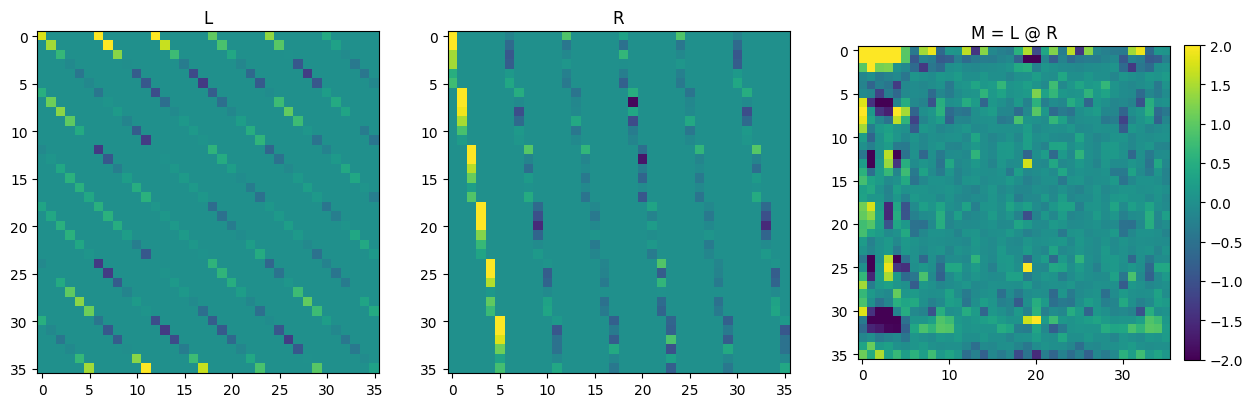

In [6]:
L, R, M, r_polys, l_polys = new_monarch(nearest_square, sqrt_N)
plot_monarch(L.real, R.real, M.real)

In [7]:
print('l_polys:')
for i, poly in enumerate(l_polys):
    print(f'l_{i}\t=\t{polystr(poly)}')

print('r_polys:')
for j1, poly in enumerate(r_polys):
    for j0, rpoly in enumerate(poly):
        print(f'r_{j1},{j0}\t=\t{polystr(rpoly)}')

l_polys:
l_0	=	0.54x^5 + 0.54x^4 + 0.03x^3 + 0.02x^2 + 0.15x^1 + 0.49
l_1	=	0.62x^5 + 0.78x^4 + 0.11x^3 + 0.98x^2 + 0.48x^1 + 0
l_2	=	0.29x^5 + 0.6x^4 + 0.67x^3 + 0.46x^2 + 0x^1 + 0
l_3	=	0.06x^5 + 0.22x^4 + 0.74x^3 + 0x^2 + 0x^1 + 0
l_4	=	0.62x^5 + 0.74x^4 + 0x^3 + 0x^2 + 0x^1 + 0
l_5	=	0.45x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0
r_polys:
r_0,0	=	0.42x^5 + 0.47x^4 + 0.89x^3 + 0.55x^2 + 0.25x^1 + 0.85
r_0,1	=	0.49x^5 + 0.74x^4 + 0.58x^3 + 0.29x^2 + 0.47x^1 + 0
r_0,2	=	0.01x^5 + 0.75x^4 + 0.39x^3 + 0.29x^2 + 0x^1 + 0
r_0,3	=	0.18x^5 + 0.72x^4 + 0.54x^3 + 0x^2 + 0x^1 + 0
r_0,4	=	0.4x^5 + 0.11x^4 + 0x^3 + 0x^2 + 0x^1 + 0
r_0,5	=	0.76x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0
r_1,0	=	0.59x^5 + 0.9x^4 + 0.14x^3 + 0.34x^2 + 0.63x^1 + 0.63
r_1,1	=	0.58x^5 + 0.04x^4 + 0.7x^3 + 0.2x^2 + 0.87x^1 + 0
r_1,2	=	0.2x^5 + 0.53x^4 + 0.56x^3 + 0.61x^2 + 0x^1 + 0
r_1,3	=	0.51x^5 + 0.2x^4 + 0.77x^3 + 0x^2 + 0x^1 + 0
r_1,4	=	0.58x^5 + 0.26x^4 + 0x^3 + 0x^2 + 0x^1 + 0
r_1,5	=	0.19x^5 + 0x^4 + 0x^3 + 0x^2 + 0x^1 + 0
r_

In [12]:
# test causality by changing the last element of u, and seeing if the output changes

u = torch.randn(N)
k = torch.randn(N)

M1 = M
M2 = M
M3 = torch.linalg.inv(M)

y = new_monarch_fft_conv(u, k, N, M1, M2, M3)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(new_monarch_fft_conv(u_changed, k, N, M1, M2, M3))

new_ys = torch.stack(new_ys)

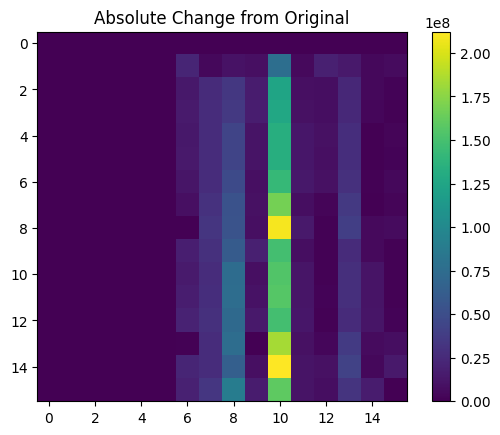

In [13]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()

# Try Block Monarch

In [79]:
R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

block_FFT_sqrt_N = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
FFT_sqrt_N = torch.view_as_complex(ref_dft_matrix(sqrt_N))
L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

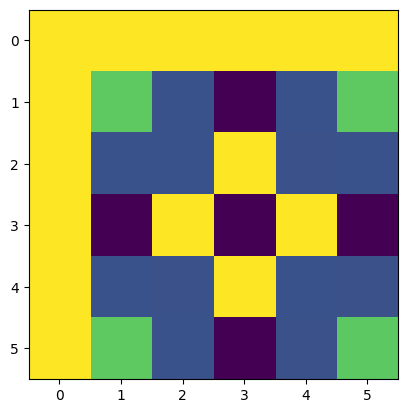

In [81]:
plt.imshow(FFT_sqrt_N.real)

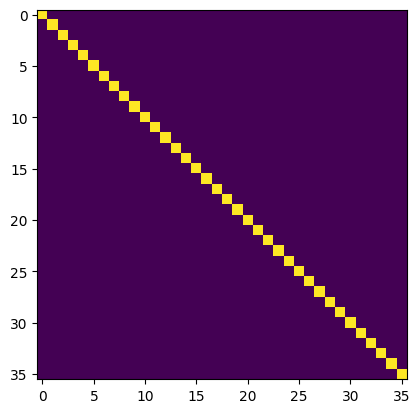

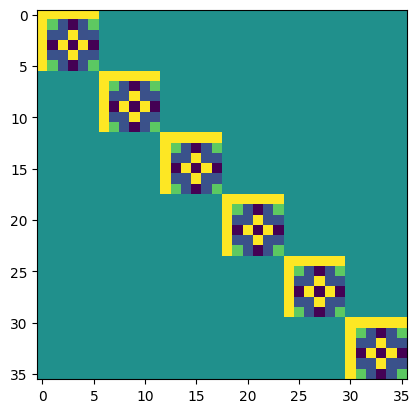

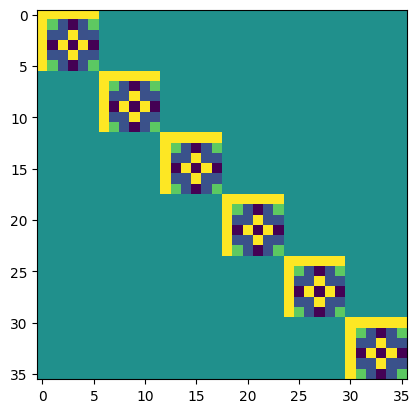

In [143]:
R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

for i in range(sqrt_N):
    # R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
    block_FFT_sqrt_N[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = FFT_sqrt_N
plt.imshow(R.real)
plt.show()
plt.imshow(block_FFT_sqrt_N.real)
plt.show()

R = block_FFT_sqrt_N @ R
plt.imshow(R.real)

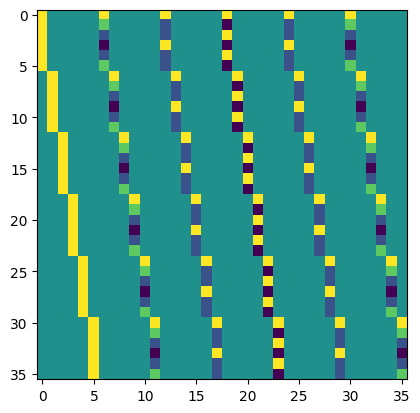

In [144]:
P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
R_diag = R
R = R @ P

plt.imshow(R.real)

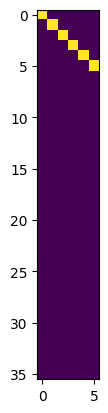

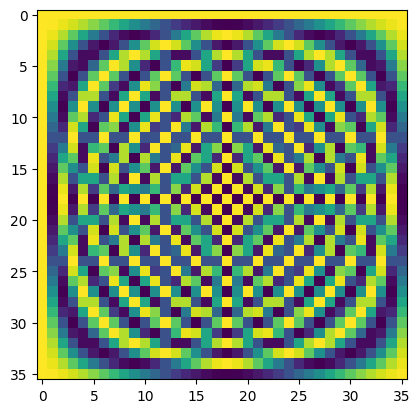

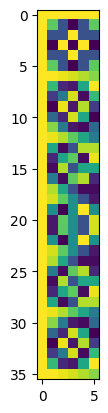

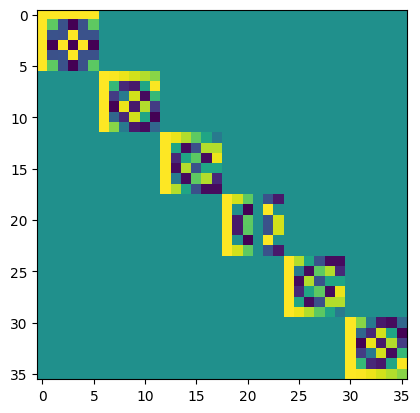

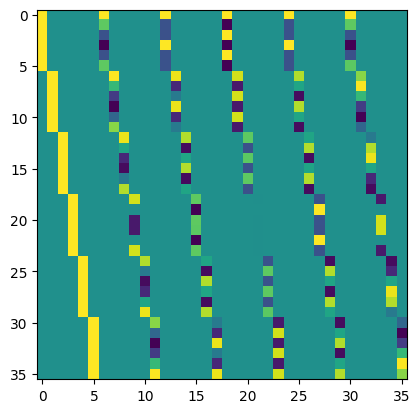

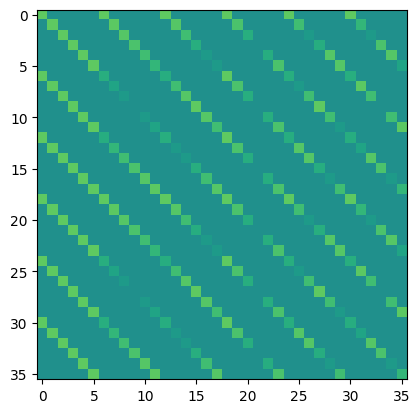

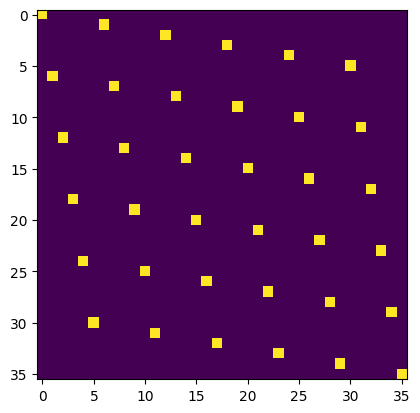

In [162]:
L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

# L_tilde_orig[:sqrt_N, :] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))

plt.imshow(L_tilde_orig.real)
plt.show()

FFT_n = torch.view_as_complex(ref_dft_matrix(nearest_square))

plt.imshow(FFT_n.real)
plt.show()

L_tilde = P @ FFT_n @ L_tilde_orig

plt.imshow(L_tilde.real)
plt.show()

for i in range(sqrt_N):
    L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]
    # L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = block_FFT_sqrt_N

# L = block_FFT_sqrt_N
L_diag = L

plt.imshow(L_diag.real)
plt.show()

L = L_diag @ P

plt.imshow(L.real)
plt.show()

L = P @ L
plt.imshow(torch.abs(L.real), vmin=-2, vmax=2)
plt.show()

plt.imshow(P.real)
plt.show()

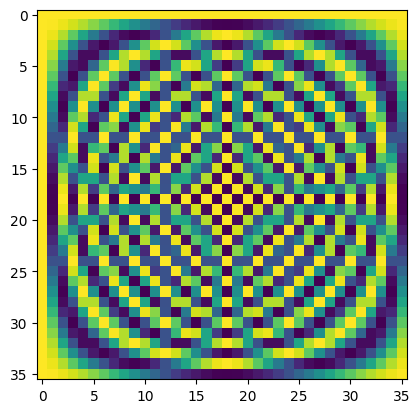

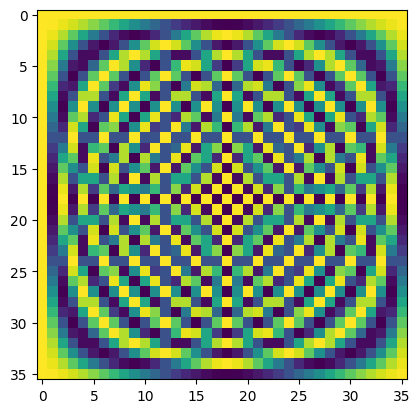

In [164]:
M = P @ L_diag @ P @ R_diag @ P
plt.imshow(M.real)

plt.show()
plt.imshow((FFT_n).real)

In [244]:
def block_monarch(nearest_square, sqrt_N):
    R = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    L = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)

    block_FFT_sqrt_N = torch.zeros(nearest_square, nearest_square, dtype=torch.cfloat)
    FFT_sqrt_N = torch.view_as_complex(ref_dft_matrix(sqrt_N))
    L_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)
    R_tilde_orig = torch.zeros(nearest_square, sqrt_N, dtype=torch.cfloat)

    # set values for R
    for i in range(sqrt_N):
        block = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
        # block = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block.fill_diagonal_(1)
        R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = block
        # R_tilde_orig[i * sqrt_N:(i + 1) * sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
        block_FFT_sqrt_N[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = FFT_sqrt_N
    
    R_tilde = R_tilde_orig

    for i in range(sqrt_N):
        R[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = R_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]

    R = block_FFT_sqrt_N @ R

    P = get_P_matrix(nearest_square, sqrt_N).to(torch.cfloat)
    R_diag = R
    R = R @ P

    # set values for L
    L_tilde_orig[:sqrt_N, :] = torch.tril(torch.randn(sqrt_N, sqrt_N, dtype=torch.cfloat))
    # L_tilde_orig[:sqrt_N, :] = torch.diag(torch.ones(sqrt_N, dtype=torch.cfloat))
    L_tilde = P @ torch.view_as_complex(ref_dft_matrix(nearest_square)) @ L_tilde_orig
    for i in range(sqrt_N):
        L[i * sqrt_N:(i + 1) * sqrt_N, i * sqrt_N:(i + 1) * sqrt_N] = L_tilde[i * sqrt_N:(i + 1) * sqrt_N, :]
    
    L_diag = L

    L = P @ L @ P

    M = L @ R

    return L, R, M, L_diag, R_diag, R_tilde_orig, L_tilde_orig

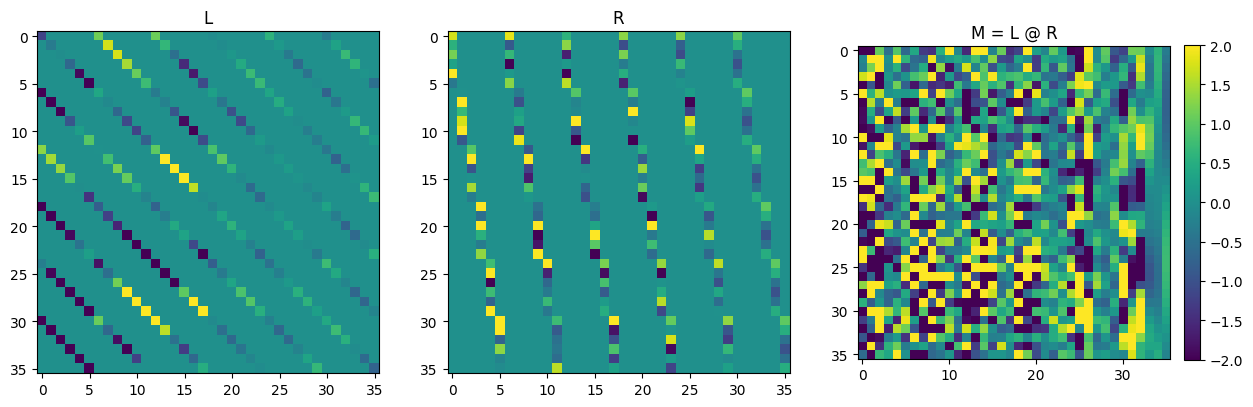

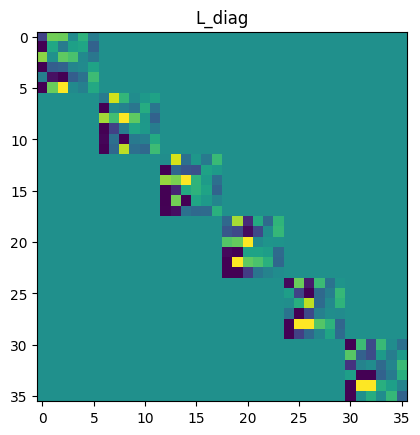

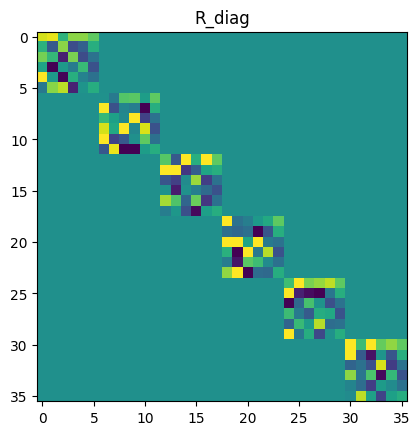

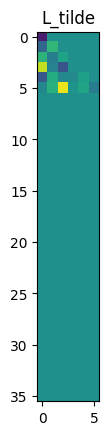

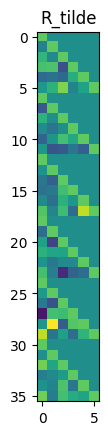

In [245]:
L, R, M, L_diag, R_diag, R_tilde, L_tilde = block_monarch(nearest_square, sqrt_N)
plot_monarch(L.real, R.real, M.real)
plt.show()

plt.title('L_diag')
plt.imshow(L_diag.real, vmin=-2, vmax=2)
plt.show()

plt.title('R_diag')
plt.imshow(R_diag.real, vmin=-2, vmax=2)
plt.show()

plt.title('L_tilde')
plt.imshow(L_tilde.real, vmin=-2, vmax=2)
plt.show()

plt.title('R_tilde')
plt.imshow(R_tilde.real, vmin=-2, vmax=2)
plt.show()

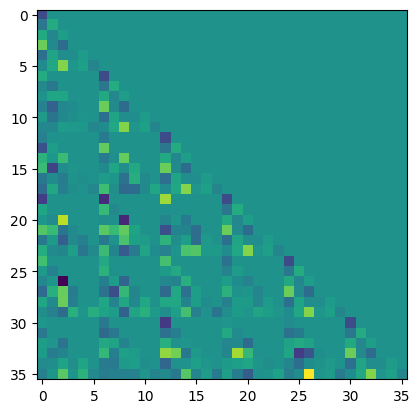

In [246]:
plt.imshow((torch.view_as_complex(ref_idft_matrix(M.shape[0])) @ M).real)

In [247]:
# test causality by changing the last element of u, and seeing if the output changes

u = torch.randn(N)
k = torch.randn(N)

M1 = M
M2 = M
M3 = torch.linalg.inv(M)
# M3 = torch.view_as_complex(ref_idft_matrix(M.shape[0]))
# M3 = M

y = new_monarch_fft_conv(u, k, N, M1, M2, M3)

new_u = torch.randn(N)
u_changed = torch.clone(u)

new_ys = []

for i in range(1, N + 1):
    u_changed[-i] = new_u[-i]
    new_ys.append(new_monarch_fft_conv(u_changed, k, N, M1, M2, M3))

new_ys = torch.stack(new_ys)

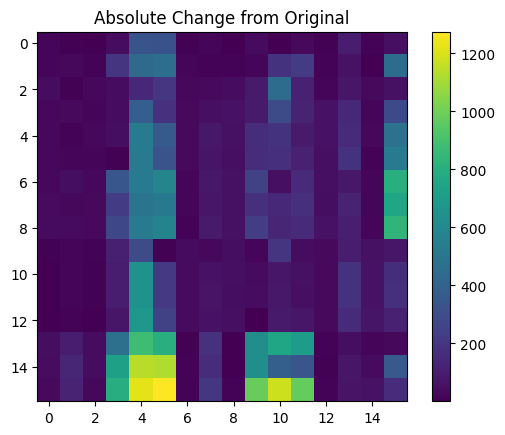

In [248]:
plt.title('Absolute Change from Original')

plt.imshow(torch.abs(new_ys - y))
plt.colorbar()